In [19]:
%load_ext autoreload
%autoreload 2
import os
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


from model import *
from model import EF, train_model
import jax
import optax
import e3x

from dcmnet.analysis import create_model_and_params
from dcmnet.data import prepare_batches, prepare_datasets
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [20]:
data_key, train_key = jax.random.split(
    jax.random.PRNGKey(19), 2)

In [21]:
files = ["/pchem-data/meuwly/boittier/home/dataset_aaa.npz"]

In [27]:
_ = np.load(files[0])
_["Z"].max()

8

In [23]:
files = ["/pchem-data/meuwly/boittier/home/dataset_aaa.npz"]

In [24]:
NATOMS = 34

In [25]:
train_data, valid_data = prepare_datasets(data_key, 10000, 2000,
                                          files, 
                                          clip_esp=False, natoms=NATOMS, clean=False)

shape (12500, 34, 3) not failed [    0     1     2 ... 12497 12498 12499]
dataR (12500, 34, 3)
D (12500, 3)
Q 1 (12500,) 12500
Q (12500,)
R (12500, 34, 3)
(12500, 34, 3)
['R', 'Z', 'F', 'E', 'N', 'D', 'Q']
12500
0 R 12500 (12500, 34, 3)
1 Z 12500 (12500, 34)
2 F 12500 (12500, 34, 3)
3 E 12500 (12500, 1)
4 N 12500 (12500, 1)
5 D 12500 (12500, 3)
6 Q 12500 (12500,)


In [30]:
model = EF(
    # attributes
    features = 128,
    max_degree = 0,
    num_iterations = 5,
    num_basis_functions = 64,
    cutoff = 10.0,
    max_atomic_number = 8,
    charges = True,
    natoms=NATOMS,
    total_charge=1,
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 8
    charges = True
    natoms = 34
    total_charge = 1
)

In [31]:
batch_size = 1

In [32]:
train_batches = prepare_batches(data_key, train_data, batch_size, 
                                data_keys=["Z", "R", "D", "E", "F"], 
                                    num_atoms=NATOMS)
for _ in train_batches[0].keys():
    print(_,train_batches[0][_].shape, train_batches[0][_].dtype)

R (34, 3) float64
Z (34,) int64
F (34, 3) float64
E (1, 1) float64
D (1, 3) float64
dst_idx (1122,) int32
src_idx (1122,) int32
batch_segments (34,) int32


In [33]:
from model import dipole_calc
# dipole_calc(train_batches[0]["R"], 
#             train_batches[0]["Z"], 
#             np.ones(len(train_batches[0]["R"])),
#             train_batches[0]["batch_segments"],
#             batch_size
#            )


In [36]:
data_keys = ["R", "Z", "F", "E", "D", "dst_idx", "src_idx", "batch_segments"]
conversion = {"energy": 1/(ase.units.kcal/ase.units.mol), "forces": 1/(ase.units.kcal/ase.units.mol)}

batch_size = 100
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    10,
    0.0001, 
    1000,
    1,
    batch_size,
    num_atoms=NATOMS,
    data_keys=data_keys,
    conversion=conversion,
    # restart = params,
)

Traced<ConcreteArray([[[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]


 [[[0.]]]], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([[[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


       [[[0.]]],


 

TypeError: cannot reshape array of shape (34, 1, 1, 34) (size 1156) into shape (34, 1) (size 34)

In [14]:
data_keys = ["R", "Z", "F", "E", "D", "dst_idx", "src_idx", "batch_segments"]
batch_size = 1
params2 = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    2,
    0.0001, 
    1000,
    1,
    batch_size,
    num_atoms=NATOMS,
    data_keys=data_keys,
    restart = params,
)

epoch:   1				 train:   valid:
    loss		[a.u.]     		 1883.108  1394.026
    energy mae		[kcal/mol]		 262.454   29.843
    forces mae		[kcal/mol/Å]		  25.157   24.573
    dipoles mae		[e Å]     		   1.059    1.209
epoch:   2				 train:   valid:
    loss		[a.u.]     		 1307.005  1253.757
    energy mae		[kcal/mol]		  35.732   37.802
    forces mae		[kcal/mol/Å]		  23.768   23.215
    dipoles mae		[e Å]     		   1.305    1.572


In [15]:
batch_size = 100
valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)
# @jax.jit
def eval():
    Es, predEs, Fs, predFs, Ds, predDs, charges, outputs = [], [], [], [], [], [], [], []
    for i, batch in enumerate(valid_batches[:]):
      output = model.apply(
        params,
        atomic_numbers=batch['Z'],
        positions=batch['R'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
      )
      Ds.append(batch["D"])
      D = dipole_calc(batch["R"], batch["Z"], output["charges"],batch['batch_segments'],batch_size)
      # print(D,batch["D"])
      predDs.append(D)
      Es.append(batch["E"])
      predEs.append(output["energy"])
      Fs.append(batch["F"])
      predFs.append(output["forces"])
      charges.append(output["charges"])
    
    Es = np.array(Es).flatten()
    predEs = np.array(predEs).flatten()
    Fs = np.array(Fs).flatten()
    predFs = np.array(predFs).flatten()
    Ds = np.array(Ds) #.flatten()
    predDs = np.array(predDs) #.flatten()
    outputs.append(output)
    return Es, predEs, Fs, predFs, Ds, predDs, charges, outputs


Es, predEs, Fs, predFs, Ds, predDs, charges, outputs  = eval()

Es = Es /(ase.units.kcal/ase.units.mol)
predEs = predEs /(ase.units.kcal/ase.units.mol)
Fs = Fs /(ase.units.kcal/ase.units.mol)
predFs = predFs /(ase.units.kcal/ase.units.mol)

In [16]:
np.mean(abs(np.linalg.norm(Ds[:10], axis=-1) - np.linalg.norm(predDs[:10], axis=-1)))

1.803822511243246

In [17]:
outputs[0]["charges"].flatten().sum()

Array(100., dtype=float32)

IndexError: index 103272 is out of bounds for axis 0 with size 2000

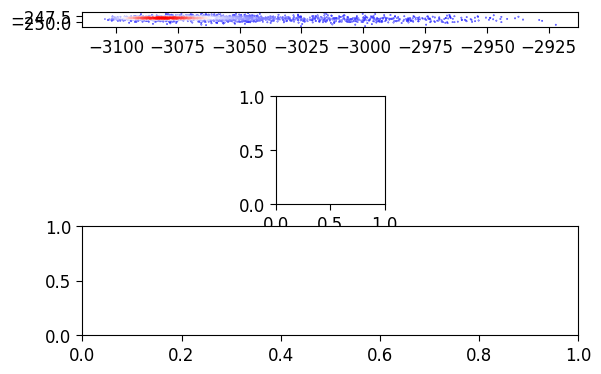

In [18]:
import ase

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(3,1)

def plot(x, y, ax):
    x = x.flatten()
    y = y.flatten()
    
    ERROR = x - y
    RMSE = np.mean(ERROR**2)**0.5
    MAE = np.mean(abs(ERROR))
    ax.set_aspect("equal")
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density (optional, for better visualization)
    idx = z.argsort()
    x, y, z = Es[idx], predEs[idx], z[idx]
    ax.scatter(x, y, alpha=1, c=z, s=0.1)
    # plt.scatter(Fs, predFs, alpha=1, color="k")
    ax.set_aspect("equal")
    return ax

plot(Es, predEs, axes[0])
plot(Fs, predFs, axes[1])
plot(Ds, predDs, axes[2])

# ERROR = Fs - predFs
# RMSE = np.mean(ERROR**2)**0.5
# MAE = np.mean(abs(ERROR))
# print(RMSE, MAE)

# plt.show()
# plt.scatter(Ds.flatten(), predDs.flatten(), alpha=1, color="k")
# ax = plt.gca()
# ax.set_aspect("equal")

# ERROR = Ds.flatten() - predDs.flatten()
# RMSE = np.mean(ERROR**2)**0.5
# MAE = np.mean(abs(ERROR))
# print(RMSE, MAE)

In [73]:
outputs[0]["electrostatics"], outputs[0]["energy"]

(Array([1.8692482, 1.440227 , 1.6149787, 1.840737 , 1.8624   , 1.7679915,
        1.8271505, 1.9074833, 1.4653504, 1.6800466, 1.7671912, 1.8306321,
        1.8535619, 1.7839442, 1.6505864, 1.7322901, 1.7130188, 1.8208593,
        1.7689544, 1.8920938, 1.7505938, 1.9282936, 1.5930066, 1.6434686,
        1.9436234, 1.8620785, 1.6313921, 1.8717804, 1.8026633, 1.8059789,
        1.8156298, 1.6862406, 1.6579261, 2.018503 , 1.9432058, 1.64041  ,
        1.4907604, 1.4715352, 1.8104184, 1.6821828, 1.5822865, 1.7838068,
        1.7787805, 1.6616966, 1.8156586, 1.7920891, 1.6379702, 1.6849184,
        1.6517148, 1.8068626, 1.7916498, 1.8155211, 1.6677938, 1.9068245,
        1.706558 , 1.8069811, 1.5894465, 1.8270601, 1.903701 , 1.6861019,
        1.5307041, 1.4828706, 1.8351645, 1.6713473, 1.6591194, 1.878962 ,
        1.7967395, 1.7342705, 1.769247 , 1.721871 , 1.9103231, 1.7209635,
        1.9373813, 1.8496732, 1.952964 , 1.7227721, 1.7046522, 1.8292489,
        1.8531293, 1.8534497, 1.856129

In [134]:
import pickle
with open(f"checkpoints/test2-q.pkl", "wb") as file:
    pickle.dump(params, file)

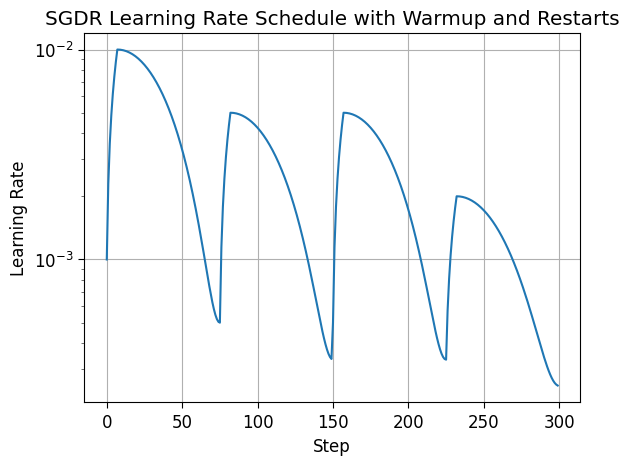

In [75]:
import optax
import matplotlib.pyplot as plt

num_epochs = 300
learning_rate = 0.001
# Define the parameters for each cosine decay cycle with warmup
cosine_kwargs = [
        {"end_value": learning_rate/2, "peak_value": learning_rate*10, "init_value": learning_rate, 
         "warmup_steps": num_epochs//40, "decay_steps": num_epochs//4},  # 
        {"end_value": learning_rate/3,"peak_value": learning_rate*5, "init_value": learning_rate/2, 
         "warmup_steps": num_epochs//40, "decay_steps": num_epochs//4},  #
        {"end_value": learning_rate/3,"peak_value": learning_rate*5, "init_value": learning_rate/2, 
         "warmup_steps": num_epochs//40, "decay_steps": num_epochs//4},  #
            {"end_value": learning_rate/4,"peak_value": learning_rate*2, "init_value": learning_rate/3, 
         "warmup_steps": num_epochs//40, "decay_steps": num_epochs//4},  # 
    ]
# Create the SGDR schedule with warm restarts
schedule_fn = optax.schedules.sgdr_schedule(cosine_kwargs=cosine_kwargs)

# Generate learning rate values for visualization
steps = range(num_epochs)  # Total steps spanning all cycles
learning_rates = [schedule_fn(step) for step in steps]

# Plot the SGDR learning rate schedule
plt.plot(steps, learning_rates)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.yscale("log")
plt.title('SGDR Learning Rate Schedule with Warmup and Restarts')
plt.grid()
plt.show()


In [76]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [136]:
from helper_mlp import get_ase_calc


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [137]:
# Initialize atoms object and attach calculator.
i = 100

Natoms = int(train_data['N'][i])
R = train_data['R'][i][:Natoms] - np.mean(train_data['R'][i][:Natoms], axis=0)
# print(R)
atoms = ase.Atoms(train_data['Z'][i][:Natoms], R )
calculator = get_ase_calc(params, model, atoms)
atoms.set_calculator(calculator)

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [138]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.001)

      Step     Time          Energy          fmax
BFGS:    0 23:00:47     -131.879730        5.191283
BFGS:    1 23:00:47     -133.310135        3.183553
BFGS:    2 23:00:47     -133.902969        2.013765
BFGS:    3 23:00:47     -134.440735        2.387133
BFGS:    4 23:00:47     -134.735519        1.391042
BFGS:    5 23:00:47     -134.930145        0.842002
BFGS:    6 23:00:47     -135.049576        0.633988
BFGS:    7 23:00:47     -135.116180        0.989491
BFGS:    8 23:00:47     -135.163071        0.701008
BFGS:    9 23:00:47     -135.198669        0.375975
BFGS:   10 23:00:47     -135.238312        0.443164
BFGS:   11 23:00:47     -135.264862        0.469540
BFGS:   12 23:00:47     -135.294312        0.536476
BFGS:   13 23:00:47     -135.325180        0.325531
BFGS:   14 23:00:47     -135.360397        0.346588
BFGS:   15 23:00:47     -135.395233        0.350182
BFGS:   16 23:00:47     -135.419617        0.361587
BFGS:   17 23:00:47     -135.436829        0.235372
BFGS:   18 23:

In [139]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [165]:
# Parameters.
temperature = 500
timestep_fs = 0.5optax cosine annealing
num_steps = 1000_00

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -134.116 ekin  2.077 etot -132.038
step  1000 epot -134.189 ekin  2.150 etot -132.039
step  2000 epot -134.159 ekin  2.118 etot -132.041
step  3000 epot -134.242 ekin  2.199 etot -132.044
step  4000 epot -133.915 ekin  1.876 etot -132.039
step  5000 epot -133.941 ekin  1.901 etot -132.039
step  6000 epot -134.087 ekin  2.047 etot -132.041
step  7000 epot -133.739 ekin  1.703 etot -132.037
step  8000 epot -134.276 ekin  2.234 etot -132.042
step  9000 epot -133.576 ekin  1.538 etot -132.037
step 10000 epot -133.625 ekin  1.587 etot -132.038
step 11000 epot -134.188 ekin  2.145 etot -132.042
step 12000 epot -133.870 ekin  1.834 etot -132.036
step 13000 epot -133.919 ekin  1.879 etot -132.039
step 14000 epot -133.798 ekin  1.757 etot -132.041
step 15000 epot -134.294 ekin  2.258 etot -132.036
step 16000 epot -133.650 ekin  1.614 etot -132.036
step 17000 epot -133.661 ekin  1.628 etot -132.033
step 18000 epot -133.826 ekin  1.791 etot -132.035
step 19000 epot -134.106 ekin  

In [175]:
# view.getModel().setCoordinates(frames[::10], 'array')
# view.animate({'loop': None, 'interval': 0.1})
# view.show()

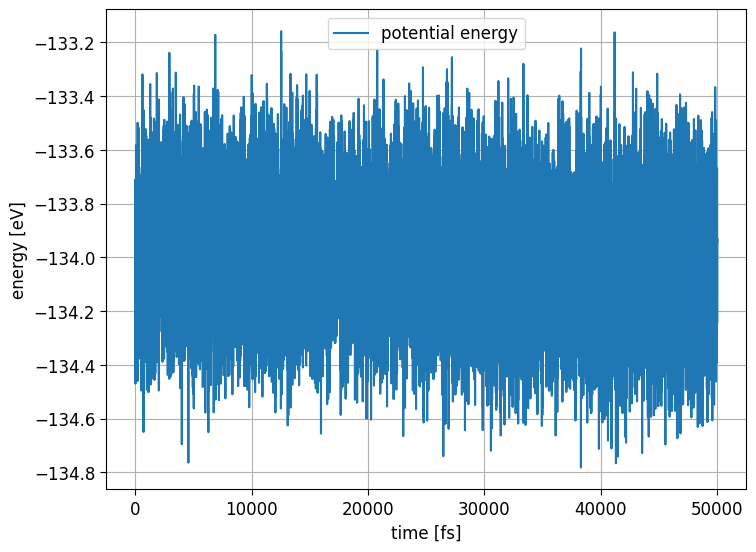

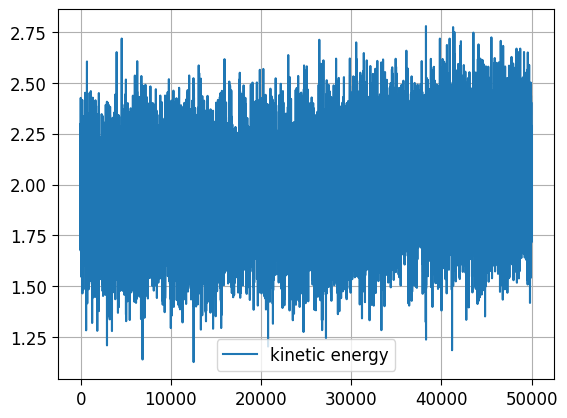

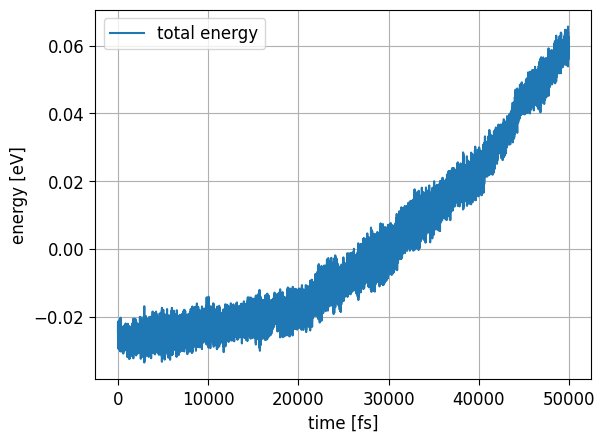

In [176]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, total_energy - total_energy.mean(), label='total energy')
plt.legend()
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
plt.grid()

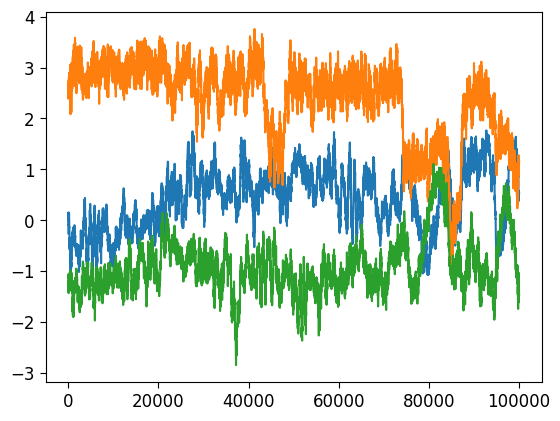

In [177]:
r = dipoles[:,0,:]
for i in range(3):
    plt.plot(r[:,i])

In [178]:
from statsmodels.tsa.stattools import acovf
10**6/1000

1000.0

In [189]:
# total_dipole_vectors = total_dipole_vectors[NSKIP::]
from ase import units

# Time for speed of light in vacuum to travel 1cm (0.01) in 1fs (1e15)
jiffy = 0.01 / units._c * 1e12

# dipo_list = np.array(total_dipole_vectors)
dtime = timestep_fs * 0.001
# Frequency range in cm^-1
Nframes = len(r)
print("Nframes: ", Nframes)
Nfreq = int(Nframes / 2) + 1

freq = np.arange(Nfreq) / float(Nframes) / dtime * jiffy

# Dipole-Dipole autocorrelation function
acvx = acovf(r[:, 0], fft=True)
acvy = acovf(r[:, 1], fft=True)
acvz = acovf(r[:, 2], fft=True)
acv = acvx + acvy + acvz

acv = acv * np.blackman(len(r))
spectra = np.abs(np.fft.rfftn(acv)) 

Nframes:  100000


(1.0, 4000.0)

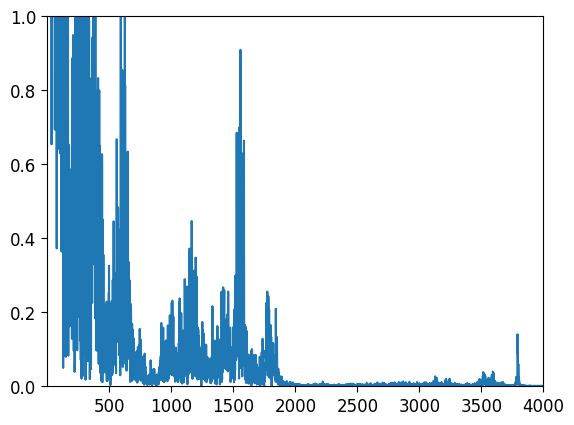

In [195]:
plt.plot(freq, spectra)
# plt.ylim(0,0.0000005)
# plt.xlim(100, 150)
# plt.yscale("log")
plt.ylim(0,1)
plt.xlim(1, 4000)

(2900.0, 3700.0)

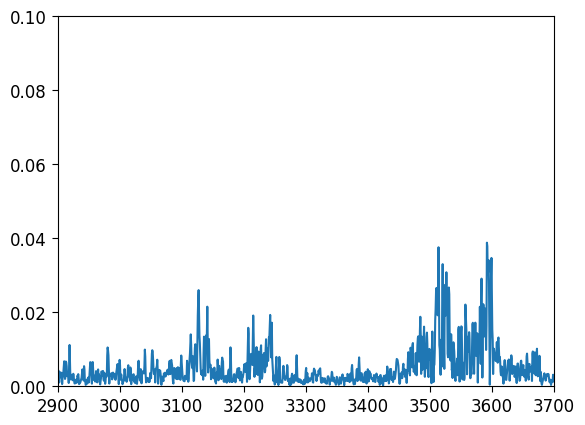

In [196]:
plt.plot(freq, spectra)
# plt.ylim(0,0.0000005)
# plt.xlim(100, 150)
# plt.yscale("log")
plt.ylim(0,0.1)
plt.xlim(2900, 3700)